<a href="https://colab.research.google.com/github/itasio/autonomous-agents-deep-rl/blob/main/cellular_automata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/elbecerrasoto/gym-cellular-automata
!pip install -e gym-cellular-automata
!pip install ipdb
import ipdb

Cloning into 'gym-cellular-automata'...
remote: Enumerating objects: 4059, done.
remote: Counting objects: 100% (564/564), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 4059 (delta 441), reused 477 (delta 395), pack-reused 3495
Receiving objects: 100% (4059/4059), 7.62 MiB | 25.83 MiB/s, done.
Resolving deltas: 100% (2534/2534), done.
Obtaining file:///content/gym-cellular-automata
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.7 MB/s eta 0:00:00
  Building editable for gym_cellular_automata (pyproject.toml) ... done
  Created wheel for gym_cellular_automata: filename=gym_cellular_automata-0.6.0-0.editable-py3-none-any.whl size=5698 sha256=7f12ab448b163bae61e605c3a84e1ec4e99888ca8f3472ece96de9ce73cbbe0b
  Stored in directory: /tmp/pip-ephem

In [2]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [3]:
%cd gym-cellular-automata

/content/gym-cellular-automata


Episode: 0 steps: 4
Episode: 1 steps: 7
Episode: 2 steps: 6
Episode: 3 steps: 6
Episode: 4 steps: 4
Episode: 5 steps: 3
Episode: 6 steps: 4
Episode: 7 steps: 5
Episode: 8 steps: 4
Episode: 9 steps: 4
Episode: 10 steps: 5
Episode: 11 steps: 4
Episode: 12 steps: 3
Episode: 13 steps: 5
Episode: 14 steps: 3
Episode: 15 steps: 2
Episode: 16 steps: 5
Episode: 17 steps: 3
Episode: 18 steps: 3
Episode: 19 steps: 4
Episode: 20 steps: 3
Episode: 21 steps: 7
Episode: 22 steps: 3
Episode: 23 steps: 6
Episode: 24 steps: 4
Episode: 25 steps: 6
Episode: 26 steps: 3
Episode: 27 steps: 2
Episode: 28 steps: 6
Episode: 29 steps: 2
Episode: 30 steps: 4
Episode: 31 steps: 4
Episode: 32 steps: 4
Episode: 33 steps: 3
Episode: 34 steps: 8
Episode: 35 steps: 3
Episode: 36 steps: 5
Episode: 37 steps: 5
Episode: 38 steps: 3
Episode: 39 steps: 5
Episode: 40 steps: 4
Episode: 41 steps: 3
Episode: 42 steps: 4
Episode: 43 steps: 5
Episode: 44 steps: 4
Episode: 45 steps: 4
Episode: 46 steps: 4
Episode: 47 steps: 4
Ep

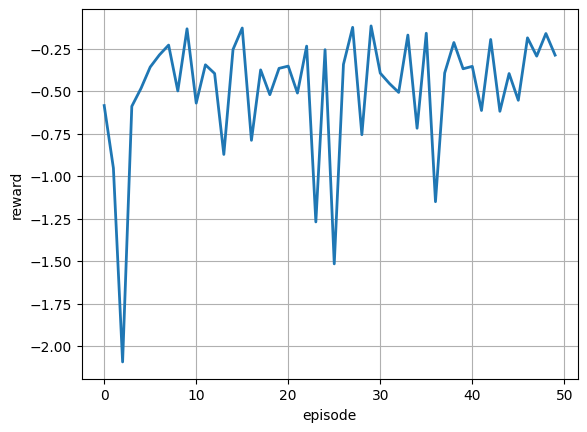

In [4]:
# @title Random agent for 100 "games"
from __future__ import print_function
import gymnasium as gym
import gym_cellular_automata as gymca
import matplotlib.pyplot as plt
import array as arr

ProtoEnv = gymca.prototypes[1]
env = ProtoEnv(nrows=9, ncols=9)

# env_id = gymca.envs[1]
# env = gym.make(env_id, render_mode="human")

episodes = 50
episode_rewards = arr.array('f')

for episode in range(episodes):
    obs, info = env.reset()

    total_reward = 0.0
    done = False
    step = 0
    threshold = 1000    # How many steps at most until an episode is completed
    # print(f"Obs: {obs}")
    # ipdb.set_trace();
    while not done and step < threshold:

        action = env.action_space.sample()  # Your agent goes here!

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        step += 1

    episode_rewards.append(total_reward)
    print(f"Episode: {episode} steps: {step}")


plt.plot(episode_rewards,linewidth=2.0)
plt.grid(True)
plt.ylabel('reward')
plt.xlabel('episode')
plt.show()
# print(f"Total Steps: {step}")
# print(f"Obs: {obs}")
# print(f"action: {action}")
# print(f"Total Reward: {total_reward}")



In [10]:
# @title DQN Agent
import numpy as np
import random
import tensorflow as tf
from collections import deque
# from tensorflow.keras import layers, models, optimizers, models

class DQNAgent:
    def __init__(self, env_state_shape, num_actions, load_model=False, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, replay_memory_capacity=1000, batch_size=32, target_update_freq=1000):
        self.env_state_shape = env_state_shape
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.replay_memory = deque(maxlen=replay_memory_capacity)
        if load_model:
            self.model = self.target_model = tf.keras.models.load_model('/content/model_for_9x9.keras')
            print(f"Model is loaded")
        else:
            self.model = self.build_model()
            self.target_model = self.build_model()  # Target network for stable updates
        self.target_update_freq = target_update_freq
        self.steps_since_target_update = 0

    def build_model(self):


        ############## Model for 9x9 grid and 84x84 Model 1 ##############
        env_input = tf.keras.layers.Input(shape=self.env_state_shape, name='env_input')


        # Get the height and width of the environment input
        height, width = self.env_state_shape


        # Reshape the 2d array
        env_reshaped = tf.keras.layers.Reshape((height, width, 1))(env_input)


        # Add convolutional layer
        conv_layer = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(env_reshaped)
        flatten_layer = tf.keras.layers.Flatten()(conv_layer)
        dense_layer = tf.keras.layers.Dense(64, activation='relu')(flatten_layer)
        output_layer = tf.keras.layers.Dense(self.num_actions, activation='linear')(dense_layer)


        model = tf.keras.models.Model(inputs=env_input, outputs=output_layer)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

        ############## 84x84 Model 2 ##############
        # env_input = tf.keras.layers.Input(shape=self.env_state_shape, name='env_input')


        # # Get the height and width of the environment input
        # height, width = self.env_state_shape


        # # Reshape the 2d array
        # env_reshaped = tf.keras.layers.Reshape((height, width, 1))(env_input)


        # # Add convolutional layer
        # conv_layer = tf.keras.layers.Conv2D(32, 8, strides=4, activation='relu')(env_reshaped)
        # conv2_layer = tf.keras.layers.Conv2D(64, 4, strides=2, activation='relu')(conv_layer)
        # conv3_layer = tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu')(conv2_layer)


        # flatten_layer = tf.keras.layers.Flatten()(conv3_layer)


        # dense_layer = tf.keras.layers.Dense(512, activation='relu')(flatten_layer)
        # output_layer = tf.keras.layers.Dense(self.num_actions, activation='linear')(dense_layer)


        # model = tf.keras.models.Model(inputs=env_input, outputs=output_layer)
        # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

        return model

    def act(self, env_state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.num_actions)
        else:
            q_values = self.model.predict(np.expand_dims(env_state, axis=0))
            return np.argmax(q_values[0])

    def remember(self, env_state, action, reward, next_env_state, done):
        self.replay_memory.append((env_state, action, reward, next_env_state, done))

    def train(self):
        if len(self.replay_memory) < self.batch_size:
            return

        minibatch = random.sample(self.replay_memory, self.batch_size)
        env_states, actions, rewards, next_env_states, dones = zip(*minibatch)
        env_states = np.array(env_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_env_states = np.array(next_env_states)
        dones = np.array(dones)

        # Compute target Q-values using the target network
        target_q_values = self.target_model.predict(next_env_states)

        # Update Q-values for the actions taken
        target_values = rewards + (1 - dones) * self.gamma * np.amax(target_q_values, axis=1)

        # Compute one-hot encoding for actions
        action_mask = np.eye(self.num_actions)[actions]

        # Compute current Q-values
        current_q_values = self.model.predict(env_states)

        # Update Q-values with target values
        for i in range(self.batch_size):
            current_q_values[i] = action_mask[i] * target_values[i]

        # Train the model
        self.model.fit(env_states, current_q_values, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network periodically
        self.steps_since_target_update += 1
        if self.steps_since_target_update >= self.target_update_freq:
            self.target_model.set_weights(self.model.get_weights())
            self.steps_since_target_update = 0


Model is loaded
now on episode: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
now on episode: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
now on episode: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
now on episode: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
now on episode: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
now on episode: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
now on episode: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
now on episode: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
now 

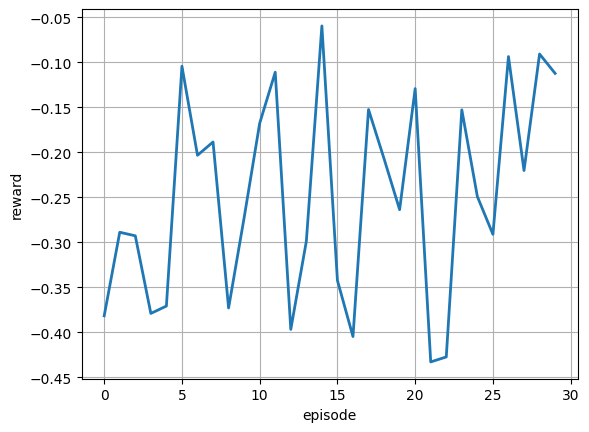

In [12]:
# @title My forest
import gymnasium as gym
import gym_cellular_automata as gymca
import array as arr
import matplotlib.pyplot as plt
# import DQNAgent as dq

def embed_pos_to_state(state, position):
    """Create a 2D array that incorporates position of the bulldozer and regularize it. Max value of state is 25

    Args:
        state: Observation of the environment
        position: Position of the bulldozer

    Return:
        The corresponding array where

        1. Empty cell with the bulldozer in it: 1 -> 1 / 25

        2. Tree cell with the bulldozer in it: 2 -> 2 / 25

        3. Fire cell with the bulldozer in it: 4 -> 4 / 25

        ------------

        Other cells:

        1. Empty cell: 0 -> 0 / 25

        2. Tree cell: 3 -> 3 / 25

        3. Fire cell: 25 -> 25 / 25
    """
    state_for_nn = state.copy()
    cell_st = state_for_nn[position[0]][position[1]]
    if cell_st == 0:    #empty
         state_for_nn[position[0]][position[1]] = 1     #empty and the bulldozer
    elif cell_st == 3:  #tree
        state_for_nn[position[0]][position[1]] = 2      #tree and the bulldozer
    elif cell_st == 25: #fire
        state_for_nn[position[0]][position[1]] = 4      #fire and the bulldozer
    state_for_nn = state_for_nn / 25
    return state_for_nn

def action_from_int(num):
    rem = num % actions_arr[0]
    if rem == num:
        action = [rem, 0]
    else:
        action = [rem,1]
    return action

def int_from_action(action):
    return action[0]+action[1]*actions_arr[0]

ProtoEnv = gymca.prototypes[1]
env = ProtoEnv(nrows=9, ncols=9)

actions_arr = env.action_space.nvec
num_of_actions = actions_arr[0]*actions_arr[1]

grid_shape = env.grid_space.shape

training = False

agent = DQNAgent(grid_shape, num_of_actions, load_model=True, epsilon=0.01)

episodes = 30

random_episodes = 300 # Want to try 300 episodes running randomly out of 1000

episode_rewards = arr.array('f')

for episode in range(episodes):
    print(f"now on episode: {episode}")
    obs, info = env.reset()

    total_reward = 0.0
    done = False
    step = 0
    threshold = 1000    # How many steps at most until an episode is completed
    # print(f"Obs: {obs}")
    while not done and step < threshold:
        state = obs[0]
        position = obs[1][1]

        state_for_nn = embed_pos_to_state(state, position)

        # if episode < random_episodes:
        #     action = env.action_space.sample()
        # else:
        action = action_from_int(agent.act(state_for_nn))

        # print(state)
        # print(position)
        # print(action)

        obs, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        total_reward += reward
        step += 1

        if training :

            next_state = obs[0]
            next_position = obs[1][1]
            next_state_for_nn = embed_pos_to_state(next_state, next_position)

            agent.remember(state_for_nn, int_from_action(action), reward, next_state_for_nn, done)

            if len(agent.replay_memory) >= agent.batch_size:
                agent.train()

    episode_rewards.append(total_reward)
    # if episode % 100 == 0:
    #     model_path = '/content/gym-cellular-automata/first_model_'+str(episode)+'_ep_no5_v1.keras'
    #     target_path = '/content/gym-cellular-automata/first_target_model_'+str(episode)+'_ep_no5_v1.keras'
    #     agent.model = tf.keras.models.load_model(model_path)
    #     agent.target_model = tf.keras.models.load_model(target_path)
    #     print(f"model now loaded: {model_path}")
    #     agent.model.save(model_path)
    #     agent.target_model.save(target_path)


if training:
   # Save the entire model and the target model as a `.keras` zip archive.
    model_path = 'first_model_'+str(episode+1)+'_ep_no5_v1.keras'
    target_path = 'first_target_model_'+str(episode+1)+'_ep_no5_v1.keras'
    agent.model.save(model_path)
    agent.target_model.save(target_path)

plt.plot(episode_rewards,linewidth=2.0)
plt.grid(True)
plt.ylabel('reward')
plt.xlabel('episode')
plt.show()


In [7]:
agent.model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ env_input (InputLayer)               │ (None, 9, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 9, 9, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,720 (1.17 MB)

 Trainable params: 101,906 (398.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,814 (796.15 KB)

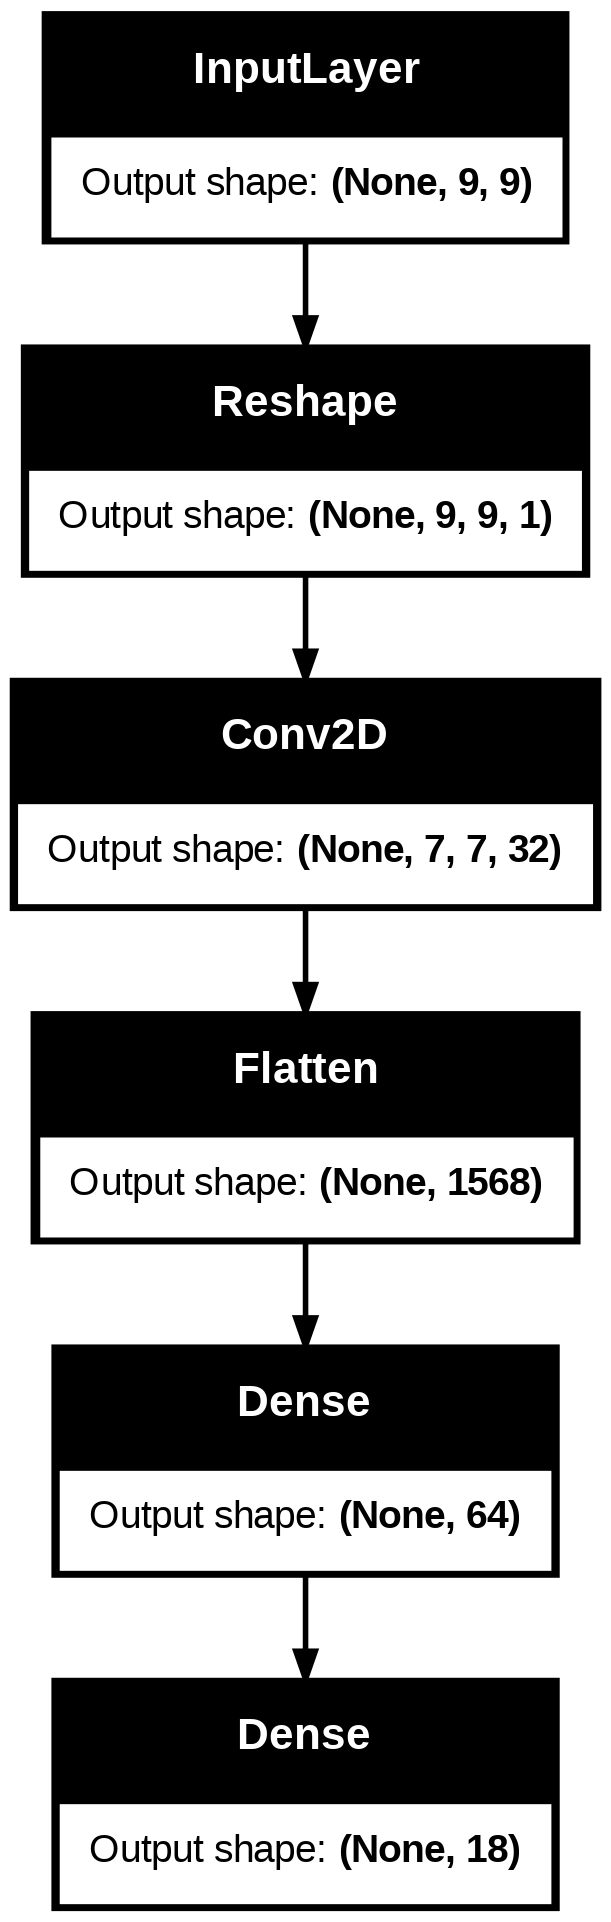

In [13]:
dot_img_file = '/tmp/model_2.png'
tf.keras.utils.plot_model(agent.model, to_file=dot_img_file, show_shapes=True)